In [4]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from astropy.stats import sigma_clip
from astropy.stats import biweight_midvariance
from astropy.stats import mad_std
import matplotlib.mlab as mlab

%matplotlib inline 
#%matplotlib notebook
%config InlineBackend.figure_format = 'retina'


(2048, 576)


/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:39: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
/opt/lsst/software/stack/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel/__main__.py:45: MatplotlibDeprecationWarning: scipy.stats.norm.pdf


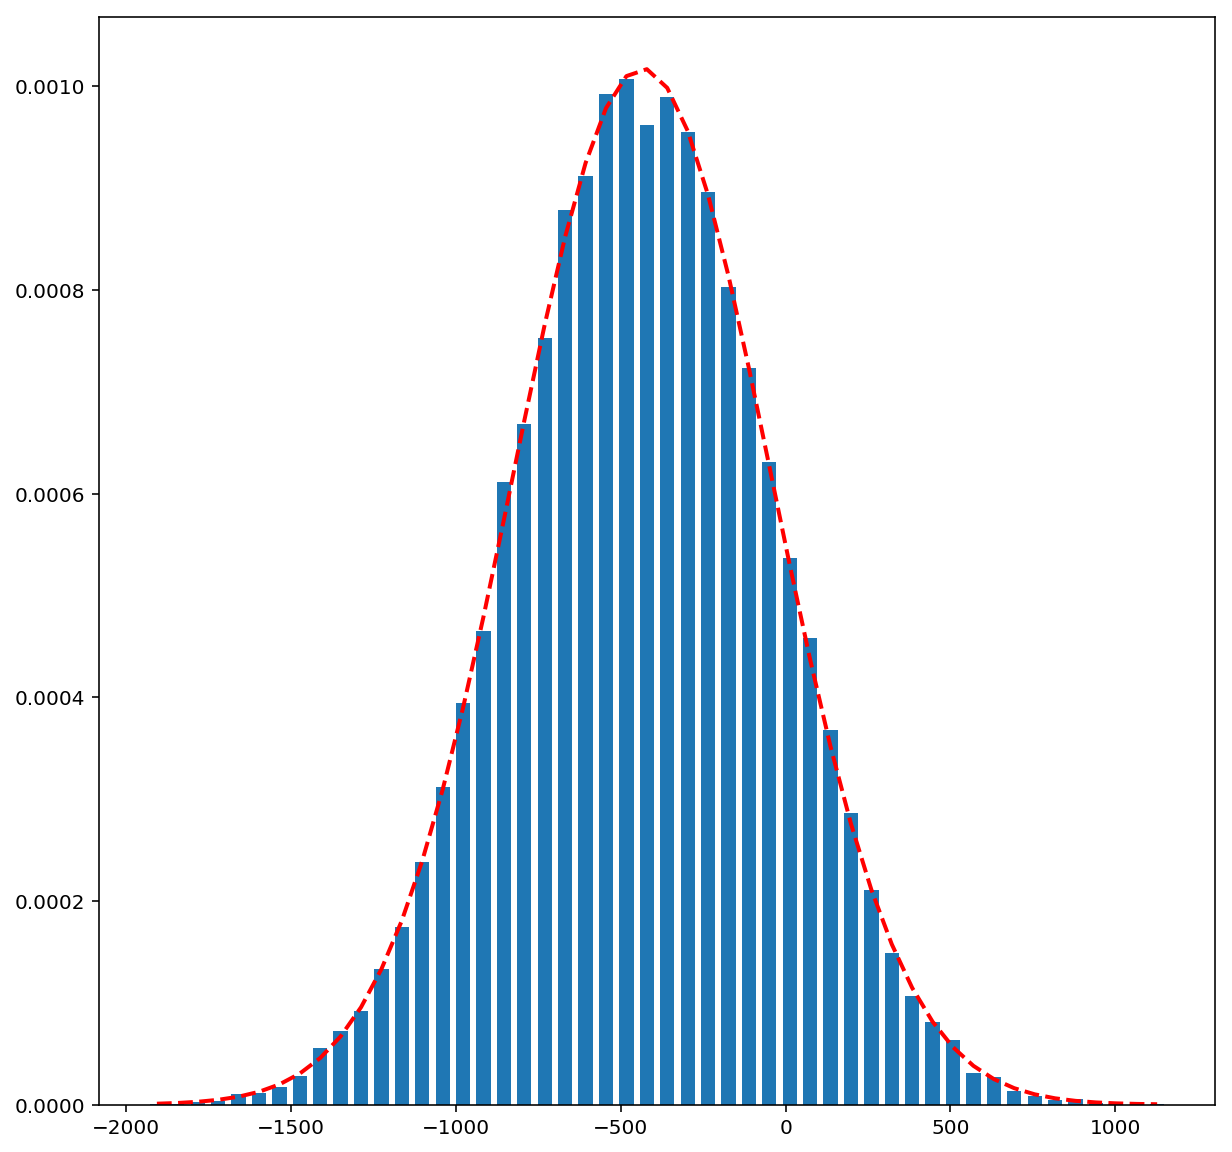

79288.7666 76844.52016714874
76844.52016714874
76844.52016714874
78546.8297760516
77764.71217100476


In [5]:
date="20190418"
xmin=150
xmax=350
ymin=150
ymax=350
amp=6

expnum=657
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S11.fits"
bias=fits.open(filename)
#print(repr(bias[0].header))

expnum=658
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S11.fits"
flat1=fits.open(filename)

expnum=659
exposure=(str(expnum).zfill(6))
filename="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+exposure+"/CC_C_"+date+"_"+exposure+"_R22_S11.fits"
flat2=fits.open(filename)
print(bias[amp].data.shape)
biasamp=bias[amp].data[ymin:ymax,xmin:xmax]
flat1amp=flat1[amp].data[ymin:ymax,xmin:xmax]
flat2amp=flat2[amp].data[ymin:ymax,xmin:xmax]

plt.rcParams['figure.figsize'] = [10, 10]
#plt.imshow(flat1amp-flat2amp)


filtered_data = sigma_clip(flat1amp-flat2amp, sigma=5, maxiters=5)
signal=np.mean( flat1amp-biasamp)
variance=0.5*np.std((flat1amp-flat2amp),dtype=np.float64)**2
variancefiltered=0.5*np.std( (filtered_data),dtype=np.float64)**2
robust_variance=0.5*biweight_midvariance(flat1amp-flat2amp)
robust_variance_mad=0.5*mad_std(flat1amp-flat2amp)**2

hist,edges=np.histogram(flat1amp-flat2amp,bins=50,normed=1)
#hist,edges=np.histogram(filtered_data,bins=50,normed=1)
width=0.7 * (edges[1]-edges[0])
centers=(edges[:-1]+edges[1:])/2

(mu, sigma) = norm.fit(flat1amp-flat2amp)
y = mlab.normpdf( centers, mu, sigma)

plt.bar(centers,hist,width=width)
plt.plot(centers, y, 'r--', linewidth=2)

plt.show()
#print(flat1amp-flat2amp)
print(signal, variance)
print(variancefiltered)
print(0.5*sigma**2)
print(robust_variance)
print(robust_variance_mad)

bias.close()
flat1.close()
flat2.close()

In [13]:
#date="20190417"
date="20190418"
xmin=150
xmax=350
ymin=150
ymax=350
amp=6

exptime = []
expnum = []
signal1 = []
signal2 = []
variance = []
sigmasqrgaussfit = []
robust_variance = []
robust_variance_mad = []

#for i in range(510,599,3):
for i in range(600,687,3):
    expnum.append(i)
    biasnum=str(i).zfill(6)
    flat1num=str(i+1).zfill(6)
    flat2num=str(i+2).zfill(6)
    biasfile="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+biasnum+"/CC_C_"+date+"_"+biasnum+"_R22_S11.fits"
    flat1file="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+flat1num+"/CC_C_"+date+"_"+flat1num+"_R22_S11.fits"
    flat2file="/project/bstalder/comcam/raw/"+date+"/CC_C_"+date+"_"+flat2num+"/CC_C_"+date+"_"+flat2num+"_R22_S11.fits"
    with fits.open(biasfile) as bias:
        biasamp=bias[amp].data[ymin:ymax,xmin:xmax]
    with fits.open(flat1file) as flat1:
        flat1amp=flat1[amp].data[ymin:ymax,xmin:xmax]
        exptime.append(flat1[0].header['EXPTIME'])
    with fits.open(flat2file) as flat2:
        flat2amp=flat2[amp].data[ymin:ymax,xmin:xmax]
    
    signal1.append(np.mean( flat1amp-biasamp ))
    signal2.append(np.mean( flat2amp-biasamp ))
    variance.append(0.5*np.std( (flat1amp-flat2amp))**2)
    (mu, sigma) = norm.fit(flat1amp-flat2amp)
    sigmasqrgaussfit.append(0.5*(sigma)**2)
    robust_variance.append(0.5*biweight_midvariance((flat1amp-flat2amp)))
    robust_variance_mad.append(0.5*mad_std((flat1amp-flat2amp))**2)


gain from variance (e/ADU): 1.0614250022192186
gain from robust variance (e/ADU): 1.0431259195924358


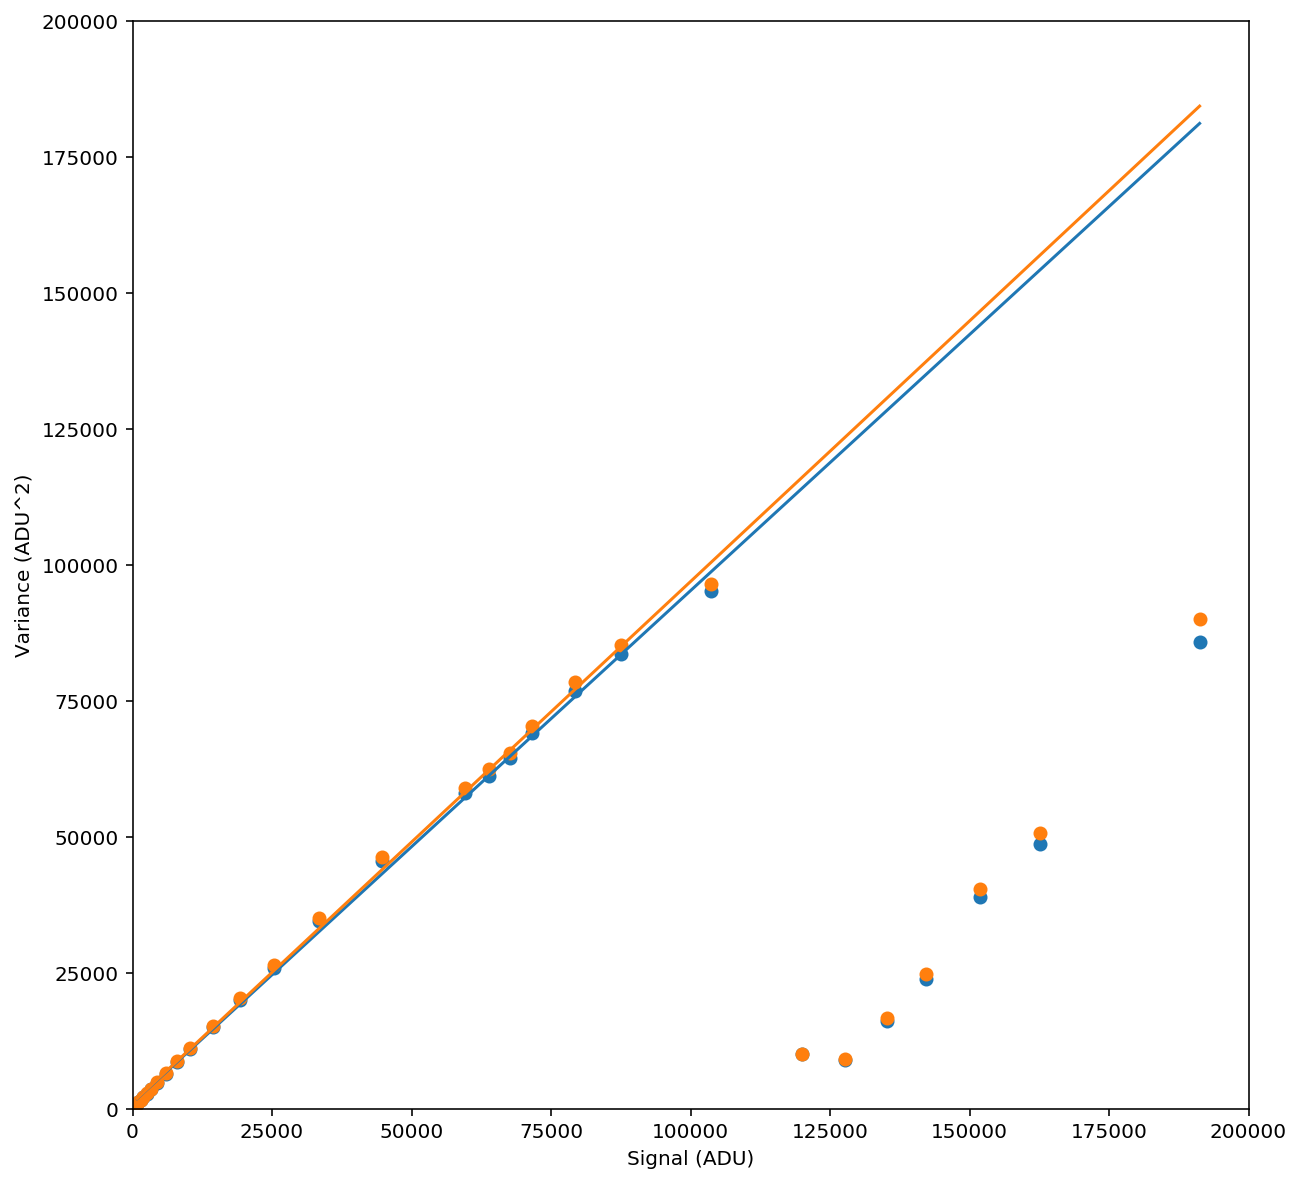

In [14]:
mask=[i for (i,j) in enumerate(signal1) if j < 110000]
sigarr=np.array(signal1)[mask]
gain_fit=np.polyfit(np.array(signal1)[mask],np.array(variance)[mask],1)
gain_fit_robust=np.polyfit(np.array(signal1)[mask],np.array(robust_variance)[mask],1)
gainfunc = np.poly1d(gain_fit)
gainfunc_robust = np.poly1d(gain_fit_robust)

print("gain from variance (e/ADU):",1/gain_fit[0])
print("gain from robust variance (e/ADU):",1/gain_fit_robust[0])
plt.figure()
#plt.scatter(signal1, signal2)
plt.scatter(signal1, variance)
plt.plot(signal1,gainfunc(signal1),'-')
#plt.scatter(signal1,sigmasqrfit)
plt.scatter(signal1,robust_variance)
#plt.scatter(signal1,robust_variance_mad)
plt.plot(signal1,gainfunc_robust(signal1),'-')

plt.xlabel('Signal (ADU)')
plt.ylabel('Variance (ADU^2)')
plt.axis([0,200000,0,200000])
plt.show()

In [8]:
for i in range(0,len(expnum)):
    print(expnum[i],exptime[i],signal1[i],signal1[i]-signal2[i],variance[i],robust_variance[i])

487 1.0 804.16605 -6.425799999999981 978.70624718 997.157643059553
490 1.3 1045.536575 -0.44830000000001746 1252.355388555 1276.0608408871856
493 1.8 1426.9864 -12.095900000000029 1654.9904265949997 1684.6324150294727
496 2.4 1901.895775 52.95765000000006 2143.3764782387493 2184.7558301171184
499 3.2 2548.458975 -22.481124999999793 2875.8535968671868 2912.1382394133866
502 4.2 3389.88785 -10.34237499999972 3745.2790271796875 3815.505392617608
505 5.6 4470.689025 -16.281025000000227 4912.407974974687 4983.855495181209
508 7.5 5800.1657 -175.99442500000077 6461.500321959688 6571.292085004128
511 10.0 7904.4283 0.6821499999996377 8563.094485688753 8749.628177462997
514 13.0 10030.5458 124.30134999999973 10701.62606908875 10891.284215923348
517 18.0 14304.839325 -5.0378749999999854 15291.832295242182 15545.582701603254
520 24.0 18815.224825 -85.53984999999739 19737.861530988754 20137.25878335515
523 32.0 25437.08975 37.0285249999979 26266.952630662185 26733.742236035247
526 42.0 33244.6553